In [1]:
__author__ = 'Robert Nikutta, NOAO Data Lab Team'
__version__ = '201705022' # yyyymmdd

# Data Lab basic functionality
*Robert Nikutta & the NOAO Data Lab Team*

<a class="anchor" id="toc"></a>
# Table of Contents
* [Module imports](#imports)
* [Get help from the helpers module: make a query object](#helpers)
* [DECaLS sky coverage](#decalssky)
 * [Query the database (synchroneously)](#sync)
 * [Plot an all-sky coverage map](#plotallsky)
 * [Compute clusters & outlines](#outlines)
* [Photometry of a field](#photometry)
 * [Get average photometry](#photometry)
 * [Asynchroneous queries](#async)
 * [Magnitude distribution and Hess diagramm](#hess)
* [Extras](#extras)

<a class="anchor" id="imports"></a>
# Module imports
Import some packages for data handling and plotting. Also import datalab code. We'll use the `helpers` module in this notebook, which hides some of the technical boilerplate.

In [2]:
# std lib
from cStringIO import StringIO
import getpass

# 3rd party
import numpy as N
import pylab as p
import matplotlib
%matplotlib inline
from IPython.display import FileLink

# Datalab
from dl import queryClient, helpers

# plots default setup
fontsize = 14
p.rcParams['font.size'] =  fontsize
p.rcParams['axes.labelsize'] = fontsize
p.rcParams['axes.titlesize'] = fontsize
p.rcParams['legend.fontsize'] = fontsize-2
p.rcParams['xtick.labelsize'] = fontsize
p.rcParams['ytick.labelsize'] = fontsize
p.rcParams['figure.figsize'] = (7, 5.8)

<a class="anchor" id="helpers"></a>
## Get help from the helpers module: make a query object
Class `Querist` from the `helpers` module makes handling your (simple) queries very easy. (But feel free to use the `authClient` and `queryClient` modules directly if needed.)

An authentication token is obtained and stored as `.token`. It is automatically used for all subsequent interactions with Data Lab.

For user `'anonymous'` there's no password dialogue, but when you supply your proper user name, you will be prompted for the password.

In [3]:
# anonymous login (some functionality is limited)
Q = helpers.Querist('anonymous') # username, here ananoymous

Authentication successful.


# _ /// Excercise 01: Log in with your proper credentials ///_
1. Editing the cell below, create a new `Querist` helper, using your own Data Lab username and password
2. Print the `.token` property of the helper object

In [4]:
# un-comment and edit the line below
#Q = helpers.Querist('anonymous') # username; when prompted, enter password

# _/// End of Excercise 01 ///_

# Querist helper supports several output formats

We will use the `Querist` instance to get some tables into RAM. Let's see what output formats are currently supported:

In [5]:
Q.output_formats

'outfmt' arg   Returned output
------------------------------
      string   CSV formatted table as a string
       array   Numpy array
 structarray   Numpy structured / record array
      pandas   Pandas dataframe
       table   Astropy Table
     votable   Astropy VOtable


You can receive your query results in any of these listed formats. If you for instance like to work with Numpy arrays, you would chose `outfmt='array'`. Or if Pandas dataframes are your forte, just use `outfmt='pandas'` in the query calls below.

<a class="anchor" id="decalssky"></a>
# Example: DECaLS sky coverage
Equipped with the `Querist` helper, we can now run some database queries. In this example we will work with the DECaLS database.

<a class="anchor" id="sync"></a>
# Query the database (synchroneously)
Let's get a sense of the DECaLS field sky coverage. Select a list of all fields (called 'bricks' in DECaLS) from the `bricks_dr3` table.

A query is just an SQL string, which we pass to the database, using the `Querist` helper.

In [6]:
# The following query selects the columns ra,dec and the number of exposures in 3 bands (g,r,z)
#    from the `bricks_dr3` table in the `ls_dr3` database.
# It also skips all rows where there are no exposures in either of the 3 bands
query = """SELECT ra,dec,nexp_g,nexp_r,nexp_z
           FROM ls_dr3.bricks_dr3
           WHERE (nexp_g+nexp_r+nexp_z)>0"""

# 'preview' sets how many rows should be printed here
result = Q(query,outfmt='structarray',preview=2)

Returning Numpy structured / record array
RESULT PREVIEW (2 rows)
ra,dec,nexp_g,nexp_r,nexp_z
315,-21.75,0,13,0
315.067064083458,-21.5,0,13,0


The result is indeed a Numpy structured array:

In [7]:
print "type(result):", type(result)
print result.dtype.names # columns names
print result[:5] # first 5 rows

type(result): <type 'numpy.ndarray'>
('ra', 'dec', 'nexp_g', 'nexp_r', 'nexp_z')
[(315.0, -21.75, 0.0, 13.0, 0.0) (315.067064083458, -21.5, 0.0, 13.0, 0.0)
 (315.268656716418, -21.75, 0.0, 13.0, 0.0)
 (315.133928571429, -21.25, 0.0, 13.0, 0.0)
 (315.335320417288, -21.5, 0.0, 13.0, 0.0)]


# _/// Excercise 02: modify the query & submit it ///_

1. In the notebook cell below, modify the previous query such that in addition to the current constraints it also ensures that the number of objects per brick is 500 or more (hint: the column name for that is `nobjs` in table `bricks_dr3` in database `ls_dr3`.)

2. Submit your query and retrieve the results as a Numpy structured array.

3. Print the column names (result.dtype.names) and last 5 rows of the array (result[-5:])

In [8]:
# un-coment and modify this query
#query = """SELECT ra,dec,nexp_g,nexp_r,nexp_z
#           FROM ls_dr3.bricks_dr3
#           WHERE (nexp_g+nexp_r+nexp_z)>0"""

# _/// End of Excercise 02 ///_

<a class="anchor" id="plotallsky"></a>
# Plot brick positions on all-sky map
Let's convert RA & Dec into radians first, and wrap-around RA at 180 degrees. This is so we can plot it easily.

In [9]:
# uses one of the Data Lab helpers
x, y = helpers.normalizeCoordinates(result['ra'],result['dec'])

Now we can plot the all-sky map, using a plotting helper

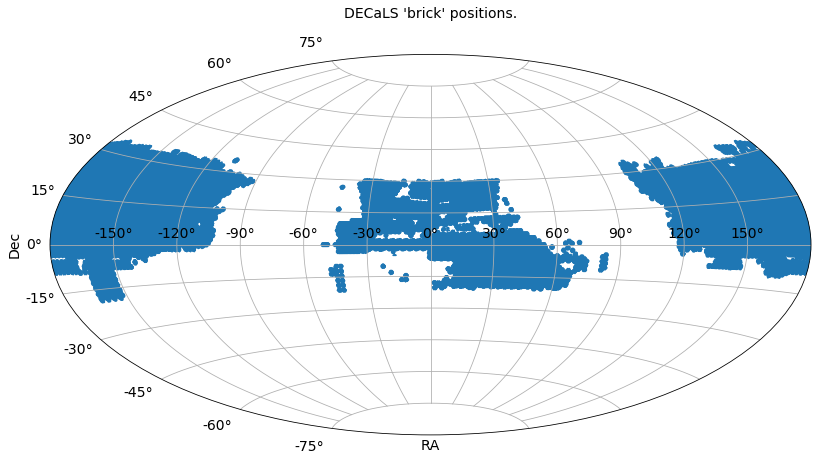

In [10]:
# uses default units 'deg' for ra & dec, converts internally to radian
helpers.plotSkymapScatter(x,y,c=None,title="DECaLS 'brick' positions.")

<a class="anchor" id="outlines"></a>
# Compute and plot sky coverage outlines
The outlines of the sky coverage can be computed as a convex hull of all points. However, because the coverage has several disjoint regions, let's automatically find clusters first.

# Automatically find clusters
Data Lab has a helper to automatically find clusters. Our helper takes x & y data as arrays (e.g. RA & Dec), and tries to find the clusters automatically. All cluster-finding algorithms from `sklearn.stats.cluster` are supported. The default method is `MiniBatchKMeans`, which is a batch version of the popular KMeans algorithm. It requires as prior the number of clusters to be found. It's fast!

In [11]:
clusters = helpers.findClusters(x,y,n_clusters=3) # uses default argument method='MiniBatchKMeans'
labels = clusters.labels_
print "Unique cluster labels:", N.unique(labels)

Unique cluster labels: [0 1 2]


Plot the clusters in different colors.

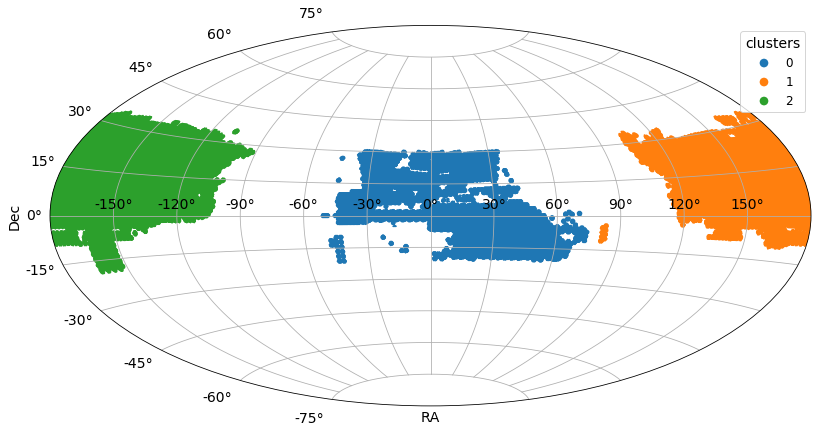

In [12]:
helpers.plotSkymapScatter(x,y,clusterlabels=labels,plot='scatter')

# Plot with automatically computed cluster outlines

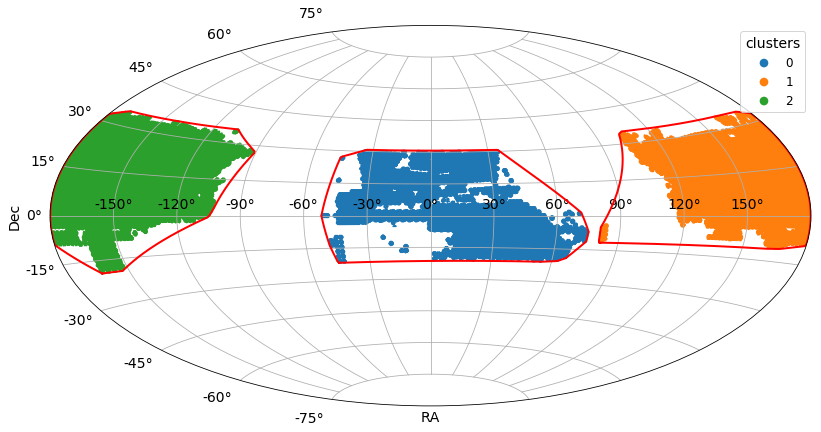

In [13]:
# plot='both' is default if clusterlabels != None
helpers.plotSkymapScatter(x,y,clusterlabels=labels,plot='both')

# Plot just the outlines

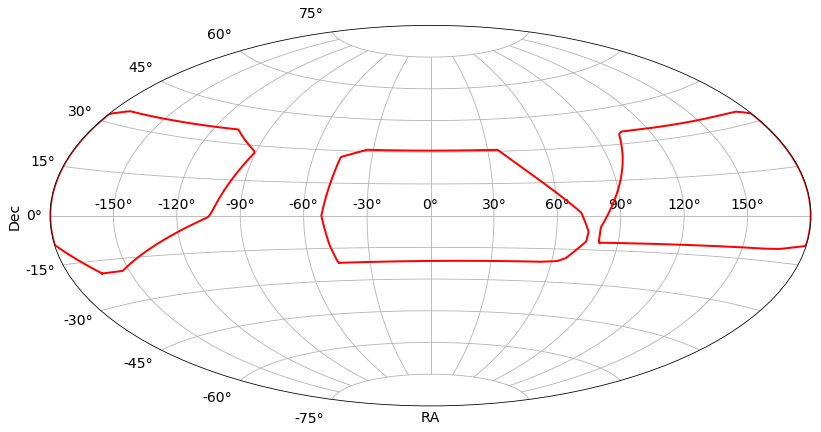

In [14]:
helpers.plotSkymapScatter(x,y,clusterlabels=labels,plot='outlines')

# _/// Excercise 03: compute and plot the footprint of the SMASH survey ///_

In the cell below:

1. Query the database table `smash_dr1.field` for columns `glon` & `glat` (Galactic longitude and latitude of the SMASH field centers)
2. Normalize the coordinates (glon,glat) --> (x,y) for plotting, using the helper `normalizeCoordinates()`
3. Compute clusters, feeding the argument `method='DBSCAN'` to `findClusters()`. Omit the `n_clusters` argument entirely. ('DBSCAN' needs no prior information on how many clusters to find, is more accurate, but can be much slower with large datasets; not here though)
4. Plot the outlines of the found clusters, i.e. the SMASH footprint.

In [15]:
# your input here

# _/// End of Excercise 03 ///_

# Plot all-sky map of DECaLS field positions
We have the positions RA & Dec, and the number of exposures in 3 bands in DECaLS. Let's plot

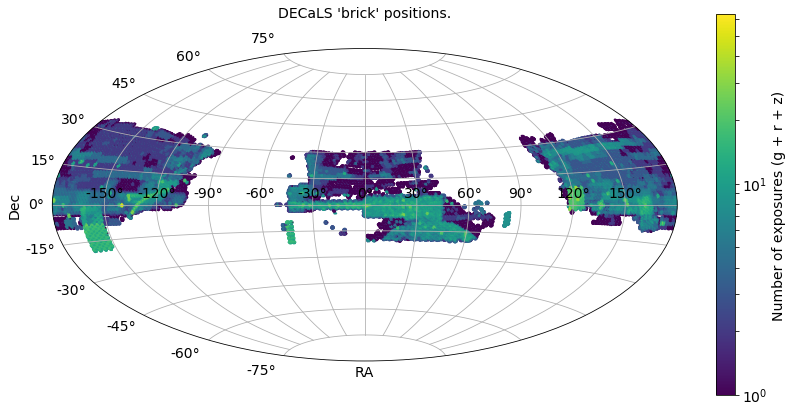

In [16]:
# compute number of exposures per brick
nexp = result['nexp_g'] + result['nexp_r'] + result['nexp_z']
helpers.plotSkymapScatter(x,y,c=nexp,title="DECaLS 'brick' positions.",clabel='Number of exposures (g + r + z)',norm=matplotlib.colors.LogNorm()) # use matplotlib.colors.Normalize() for linear color scaling

<a class="anchor" id="photometry"></a>
# Average photometry of all objects in one field
We'll select the g & r mags from fields in DECaLS and produce mag distributions and color-magnitude diagrams.

<a class="anchor" id="async"></a>
# Asynchroneous query
A large query could take some time to complete. Then it's a good idea to submit it in async mode, come back later to check its status, and when the status is 'COMPLETED', retrieve the results.

In [17]:
def makequery(ra0,dec0,fov=2.):  # all in degrees
    fov2 = fov/2.
    ralo, rahi = ra0-fov2, ra0+fov2
    declo, dechi = dec0-fov2, dec0+fov2
    # In DECaLS, bands 2 & 3 = g & r; we're selecting mags g & r, and compute signal-to-noise rations for g & r on the fly
    query = """SELECT g, r, decam_flux_2*sqrt(decam_flux_ivar_2) as snr_g, decam_flux_3*sqrt(decam_flux_ivar_3) as snr_r FROM ls_dr3.tractor_primary
               WHERE
                 g != 'nan' AND g != 'inf' AND
                 r != 'nan' AND r != 'inf' AND
                 ra BETWEEN %g AND %g AND
                 dec BETWEEN %g AND %g""" % (ralo,rahi,declo,dechi)
    return query

Generate query string, and submit the query in async mode:

In [18]:
q1 = makequery(242,8)
field1 = Q(q1,outfmt='structarray',preview=2,async=True)

Asynchronous query submitted as jobid=o7i2bgh7usbbm6be
Get results a bit later with: result = Q()


Let's see what async jobs are in the queue

In [19]:
Q.openjobs

deque([('o7i2bgh7usbbm6be', 'structarray', 2)])

Every async query submitted via `Q` is a tuple (`jobid`,`outfmt`,`preview`), where `jobid` is a unique job identifier string, and the rest is what's needed to retrieve the result.

Multiple jobs can be submitted asynchroneously, `Querist` will keep track of them in a FIFO queue (first-in-first-out):

In [20]:
# a different field; and a different outfmt for fun
field2 = Q(makequery(0.,0.),outfmt='pandas',preview=2,async=True)

Asynchronous query submitted as jobid=t5kjb26z2r5fsk5i
Get results a bit later with: result = Q()


And check the queue again...

In [21]:
Q.openjobs

deque([('o7i2bgh7usbbm6be', 'structarray', 2),
       ('t5kjb26z2r5fsk5i', 'pandas', 2)])

It now shows two asynchroneously submitted queries, waiting for completion.

Let's try to retrieve the result of the first query (field1). If its status is not yet COMPLETED, it will be *automatically* re-inserted into the queue, at its old position; no *queue jumping* ;-)

In [22]:
field1 = Q() # no arguments = get the first async job in the queue

jobid, outfmt, preview o7i2bgh7usbbm6be structarray 2
Async query job o7i2bgh7usbbm6be is COMPLETED. Attempting to retrieve results.
Returning Numpy structured / record array
RESULT PREVIEW (2 rows)
g,r,snr_g,snr_r
22.297174,21.388155,43.751050030486788,47.725968258067603
26.189589,24.130827,1.2177637774679491,3.2443616321515356


Check the async job queue again...

In [23]:
Q.openjobs

deque([('t5kjb26z2r5fsk5i', 'pandas', 2)])

Looks like the `field1` query result has been retrieved, and the job removed from the queue. Let's check it out:

In [24]:
print type(field1)
print field1.dtype.names
print field1['g'][:5]

<type 'numpy.ndarray'>
('g', 'r', 'snr_g', 'snr_r')
[ 22.297174  26.189589  23.661142  22.600121  25.417128]


Now let's retrieve the results requested in the 2nd async query

In [25]:
field2 = Q()

jobid, outfmt, preview t5kjb26z2r5fsk5i pandas 2
Async query job t5kjb26z2r5fsk5i is COMPLETED. Attempting to retrieve results.
Returning Pandas dataframe
RESULT PREVIEW (2 rows)
g,r,snr_g,snr_r
25.230408,24.436705,3.8505477601532694,6.6294923266029393
26.416374,24.423555,1.2876804723813484,6.6995190396918263


How does this one look?

In [26]:
print type(field2)
print field2['g'][:3]

<class 'pandas.core.frame.DataFrame'>
0    25.230408
1    26.416374
2    24.637480
Name: g, dtype: float64


<a class="anchor" id="hess"></a>
# Plot histograms and a color-magnitude diagram
Let's plot the g magnitude distribution and the color-magnitude diagrams of both DECaLS fields. We define a little plotting function for convenience.

In [27]:
def plotpanel(fig,axspec,x,y=None,xlabel='',ylabel=''):
    ax = fig.add_subplot(axspec)
    if y is None:
        ax.hist(x,bins=30,histtype='step',color='b',label='g',lw=2,alpha=0.6)
        ax.set_yscale('log')
        ax.set_ylabel('number of sources / bin')
        ax.set_title('nobj=%d' % x.size)
    else:
        im = ax.hexbin(x,y,gridsize=200,norm=matplotlib.colors.LogNorm())
        cb = p.colorbar(im,aspect=40,pad=0.01)
        cb.set_label('number of sources per 2D bin')
        ax.set_xlim(-2,3)
        ax.set_ylim(25,10)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

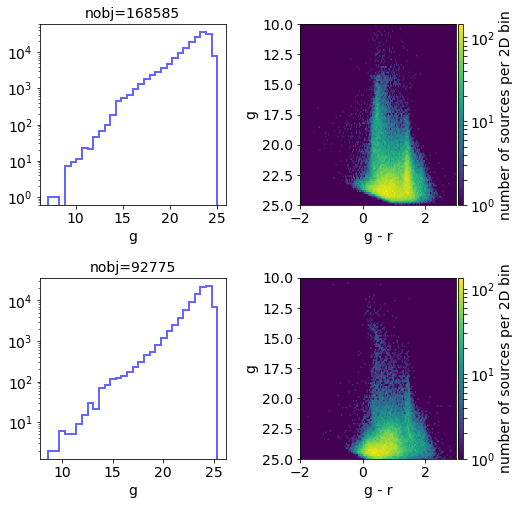

In [28]:
ok1 = (field1['snr_g'] > 5) & (field1['snr_r'] > 5) # selections as boolean arrays
ok2 = (field2['snr_g'] > 5) & (field2['snr_r'] > 5)

fig = p.figure(figsize=(8,8))
plotpanel(fig,221,field1['g'][ok1],xlabel='g')
plotpanel(fig,222,(field1['g']-field1['r'])[ok1],field1['g'][ok1],xlabel='g - r',ylabel='g')
plotpanel(fig,223,field2['g'][ok2],xlabel='g')
plotpanel(fig,224,(field2['g']-field2['r'])[ok2],field2['g'][ok2],xlabel='g - r',ylabel='g')
fig.subplots_adjust(hspace=0.4,wspace=0.4)

# Clear the async queue (e.g. if you're just playing around)
Say you populated the async queue with jobs, but you are no longer interested in them. Or you need a clean queue to start fresh.

In [29]:
res1 = Q(makequery(0,0),async=True)
res2 = Q(makequery(20,30),async=True)
Q.openjobs

Asynchronous query submitted as jobid=h93vbllq0rltcwqs
Get results a bit later with: result = Q()
Asynchronous query submitted as jobid=azpgdl9ixi50ul20
Get results a bit later with: result = Q()


deque([('h93vbllq0rltcwqs', 'array', 0), ('azpgdl9ixi50ul20', 'array', 0)])

You can clear the queue like this

In [30]:
Q.clearQueue()
Q.openjobs

Clearing the queue of async queries.


deque([])

#### <font color='red'>Q.token is your personal acces token, and valid across sessions. Once you're done working with a notebook, you may wish to clear the authentication token by executing once:_</font>

``` python
Q.clearToken()
```

In [31]:
Q.clearToken()

<a class="anchor" id="extras"></a>
# Extras

# Low-level methods
Helpers can make life easier. But when a helper is not available (write one yourself!), or the circumstances require it, you can always use the lower-level Data Lab functions directly. Here a few examples.

# Log-in and obtain an authentication token

In [32]:
from dl import authClient
token = authClient.login('USERNAME',getpass.getpass()) # replace USERNAME with your username, enter password when prompted

········


# Run a *sync* query

In [33]:
from dl import queryClient
query = 'SELECT ra,dec,gmag FROM smash_dr1.object WHERE gmag BETWEEN 9 AND 25 LIMIT 5'
response = queryClient.query(token,query,fmt='csv')
print response

ra,dec,gmag
103.86068419671366,-37.947868036194649,19.704004
103.86478726875207,-37.941059193867886,23.347004
103.86808699167489,-37.944350133401642,21.989004
103.87057221908313,-37.939550371681193,19.992004
103.87496546465509,-37.941614899354803,20.705004



# Run an *async* query and retrieve results

In [34]:
import time
query = 'SELECT ra,dec,gmag FROM smash_dr1.object WHERE gmag BETWEEN 9 AND 25 LIMIT 5'
jobid = queryClient.query(token,query,fmt='csv',async=True)
status = ''
while status != 'COMPLETED':
    status = queryClient.status(token,jobid)
    print status
    time.sleep(1)

result = queryClient.results(token,jobid)
print response

EXECUTING
EXECUTING
COMPLETED
ra,dec,gmag
103.86068419671366,-37.947868036194649,19.704004
103.86478726875207,-37.941059193867886,23.347004
103.86808699167489,-37.944350133401642,21.989004
103.87057221908313,-37.939550371681193,19.992004
103.87496546465509,-37.941614899354803,20.705004



In [35]:
result = queryClient.results

# Manually convert the result to a data structure

## To Numpy array

In [36]:
from cStringIO import StringIO
query = 'SELECT ra,dec,gmag FROM smash_dr1.object WHERE gmag BETWEEN 9 AND 25 LIMIT 5'
response = queryClient.query(token,query,fmt='csv')
ar = N.loadtxt(StringIO(response),skiprows=1,delimiter=',')
print ar.shape

(5, 3)


## To Pandas data frame

In [37]:
import pandas as pd
df = pd.read_csv(StringIO(response))
print df

           ra        dec       gmag
0  103.860684 -37.947868  19.704004
1  103.864787 -37.941059  23.347004
2  103.868087 -37.944350  21.989004
3  103.870572 -37.939550  19.992004
4  103.874965 -37.941615  20.705004


# Automatically save the query result to a file on your vospace

In [38]:
query = 'SELECT ra,dec,gmag FROM smash_dr1.object WHERE gmag BETWEEN 9 AND 25 LIMIT 5'
response = queryClient.query(token,query,fmt='csv',out='vos://foo.csv')

# List the contents of your vospace

In [39]:
from dl import storeClient
storeClient.ls(token,'vos://')

'foo.csv,public,tmp'

# Copy a file from vospace to where this notebook lives

In [40]:
res = storeClient.get(token,'vos://foo.csv','foo.csv')  # token, location in vospace, what name you want the file to be locally
FileLink("foo.csv") # display here a link to the local copy

get: nm = vos://foo.csv
get: flist = ['vos://foo.csv']
(1/1) [====================] [   257B] foo.csv


/net/dl1/users/robert/notebooks/foo.csv

# Delete a file from vospace

In [41]:
print "Before:", storeClient.ls(token,'vos://')
storeClient.rm(token,'vos://foo.csv')
print "After:", storeClient.ls(token,'vos://')

Before: foo.csv,public,tmp
http://dlsvcs.datalab.noao.edu/storage/rm?file=vos://foo.csv
After: public,tmp


# Store the query result to mydb

In [42]:
query = 'SELECT ra,dec,gmag FROM smash_dr1.object WHERE gmag BETWEEN 9 AND 25 LIMIT 5'
response = queryClient.query(token,sql=query,out='mydb://table1')

# List tables in your mydb

In [43]:
print queryClient.list(token)

table1



# Load data from a table in mydb

In [44]:
# still in alpha, may or may not work right now
query = "SELECT * FROM mydb://table1"
response = queryClient.query(token,sql=query)
print response

ra,dec,gmag
103.860684196714,-37.9478680361946,19.704
103.864787268752,-37.9410591938679,23.347
103.868086991675,-37.9443501334016,21.989
103.870572219083,-37.9395503716812,19.992
103.874965464655,-37.9416148993548,20.705



# Delete (drop) a table in mydb

In [45]:
print "Before:", queryClient.list(token)
queryClient.drop(token,'table1')
print "After:", queryClient.list(token)

Before: table1

After: relation "" not known
